# Fine-tuning a BERT model for Classification

Fine-tuning a [BERT](https://huggingface.co/docs/transformers/en/model_doc/bert) (Bidirectional Encoder Representations from Transformers) model for classification tasks involves adapting this pre-trained model to perform specific text classification tasks. Here’s a straightforward introduction to the concept.

BERT is a type of transformer model that was pre-trained on a large corpus of text. It uses a mechanism known as [attention](https://arxiv.org/abs/1706.03762), allowing the model to weigh the importance of different words relative to others for a better understanding of context. This model was designed to pre-train deep bidirectional representations by jointly conditioning on both left and right context in all layers. As a result, the pre-trained BERT model can be fine-tuned with just one additional output layer to create state-of-the-art models for a wide range of tasks, such as question answering and sentiment analysis, without substantial modifications.

The [Transformers library](https://huggingface.co/docs/transformers/en/index), provides a collection of pre-trained models like BERT, GPT (Generative Pre-trained Transformer), and others for Natural Language Processing (NLP). The library offers APIs to easily import and use these models. Both BERT and GPT are based on the transformer architecture but serve different purposes; BERT is designed to refine the understanding of sentence context and relations, making it ideal for classification tasks. In contrast, GPT is oriented towards generating text based on the input given.

Fine-tuning BERT for classification involves:
1. **Initializing BERT with pre-trained weights**: These weights have learned underlying patterns in language from its training dataset, typically datasets like Wikipedia.
2. **Adding a classification layer**: This layer will make predictions based on the representations from BERT.
3. **Training the model on a specific dataset**: This step adapts BERT’s weights slightly to the nuances of the classification task at hand, without losing the generalized understanding it has developed.

This process customizes BERT to effectively perform on specific classification tasks by leveraging both its pre-trained general understanding of language and its capacity to adapt to particular contexts.

Let's start with a very simple classification example, where we will fine-tune a pre-trained BERT model to classify text into a set of emotion classes.

## TensorFlow and Transformers library

For context, here are the versions of TensorFlow, the Transformers library and TensorFlow-Metal used in this experiment.

In [1]:
# Import the libraries
import tensorflow as tf
from transformers import __version__ as transformers_version

# Print TensorFlow and Keras version
print("TensorFlow Version:", tf.__version__)

# Print Transformers (Hugging Face BERT) version
print("Transformers Version:", transformers_version)

!pip list | grep tensorflow-metal


TensorFlow Version: 2.16.1
Transformers Version: 4.39.3
tensorflow-metal              1.1.0


## Loading the dataset

We will use the [Emotion Dataset](https://huggingface.co/datasets/emotion) from the Hugging Face datasets library. This dataset contains text samples labeled with one of six emotions: sadness, joy, love, anger, fear and surprise. We will use this dataset to fine-tune a pre-trained BERT model for text classification. In this case we will use the `kaggle` library to download the dataset directly.

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Download dataset
!kaggle datasets download -d nelgiriyewithana/emotions -p .data/ --unzip

# Load the dataset
data = pd.read_csv('.data/text.csv')

# Drop the first column
data = data.drop(data.columns[0], axis='columns')

# Display the first few rows of the dataframe
data.head()

Dataset URL: https://www.kaggle.com/datasets/nelgiriyewithana/emotions
License(s): other
 96%|████████████████████████████████████▎ | 15.0M/15.7M [00:02<00:00, 8.81MB/s]
100%|██████████████████████████████████████| 15.7M/15.7M [00:02<00:00, 7.10MB/s]


,text,label
0,i just feel really helpless and heavy hearted,4
1,ive enjoyed being able to slouch about relax a...,0
2,i gave up my internship with the dmrg and am f...,4
3,i dont know i feel so lost,0
4,i am a kindergarten teacher and i am thoroughl...,4


And let us take a look at the shape of the dataframe - as expected it has 6 target classes, and is composed of just over 400K samples.

In [3]:
# Print the shape of the dataframe
print(data.shape)

# And let us count the number of unique categories
n_categories = data['label'].nunique()
print(n_categories)

(416809, 2)
6


Labels have the following meanings:

- 0: Sadness
- 1: Joy
- 2: Love
- 3: Anger
- 4: Fear
- 5: Surprise


It is also important to note that the dataset is imbalanced, with the majority of samples belonging to the 'sadness' and 'joy' class. This imbalance will be important to understand the results of the finetuned model later on.

In [4]:
# Build a dictionary of categories
categories = ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']

# Count the number of texts in each category, and convert the numerical value to a textual one
data['label'].value_counts()

label
1    141067
0    121187
3     57317
4     47712
2     34554
5     14972
Name: count, dtype: int64

Now let us prepare a tokenizer, ready to be used with the BERT model. We will use the `distilbert-base-uncased` model, which is a smaller version of the BERT model, but which retains most of it's performance. This will allow us to train the model faster, and with less computational resources.

In [5]:
from transformers import DistilBertTokenizer

foundation_model_name = 'distilbert-base-uncased'

# Load the BERT tokenizer
tokenizer = DistilBertTokenizer.from_pretrained(foundation_model_name)

## Preparing the data

We also need to split the dataset into 'X' (features) and 'y' (target). We will also tokenize the text samples, and pad them to a fixed length of 512 tokens, which is the maximum length that the BERT model can handle. Notice how the tokenizer also adds special tokens to the input, such as the `[CLS]` token at the beginning of the input, and the `[SEP]` token at the end of the input. 

In [6]:
import numpy as np

X = data['text']
y = data['label']

X_tokenized = [tokenizer(text, max_length=512, padding='max_length', truncation=True)['input_ids'] for text in X]
X_tokenized = np.array(X_tokenized)

# Show the shape of X_tokenized
print(X_tokenized.shape)

# And the first element
X_tokenized[0]

# And the decoded text of the first element
tokenizer.decode(X_tokenized[0])

(416809, 512)


'[CLS] i just feel really helpless and heavy hearted [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]

As a last step before training the model, we will split the dataset into training and validation sets. We will use 80% of the data for training, and 20% for validation.

In [7]:
from sklearn.model_selection import train_test_split

# Split the dataset into training and testing sets, we do not use a contant random state as we want to have different splits each time we run the code

X_tokenized_train, X_tokenized_test, y_train, y_test = train_test_split(X_tokenized, y, test_size=0.2)

print(X_tokenized_train.shape)
print(X_tokenized_test.shape)

(333447, 512)
(83362, 512)


## Preparing the model

We will use the `TFDistilBertForSequenceClassification` class from the Transformers library to create a model for text classification.

In [8]:
from transformers import TFDistilBertForSequenceClassification
from transformers import DistilBertConfig

# Configure the model, there are a number of things we will leave untouched. 
model_config = DistilBertConfig.from_pretrained(foundation_model_name, num_labels=n_categories)

#model = TFBertForSequenceClassification.from_pretrained(foundation_model_name, config=model_config)
model = TFDistilBertForSequenceClassification.from_pretrained(foundation_model_name, config=model_config)

# Print the model configuration
print(model.config)


2024-04-20 16:33:52.952624: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2024-04-20 16:33:52.952656: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 24.00 GB
2024-04-20 16:33:52.952670: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 8.00 GB
2024-04-20 16:33:52.952700: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-04-20 16:33:52.952724: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_projector.bias', 'vocab_transfor

DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4,
    "LABEL_5": 5
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.39.3",
  "vocab_size": 30522
}



Here's a brief overview of the model configuration above:

- `dim` (Dimensionality of the Encoder Layers and Pooler Layer)

    Value: 768

    This parameter represents the size of the hidden layers, i.e., the dimensionality of the output vectors (embeddings) for each token in the input sequence. A dim of 768 means that every token processed by DistilBERT is converted into a vector with 768 elements. This is a standard dimension for smaller models like BERT-base, providing a good balance between computational efficiency and capacity to capture useful information in embeddings.

- `hidden_dim` (Dimensionality of the Feed-Forward Layers within the Transformer)

    Value: 3072

    This parameter specifies the size of the feed-forward layers within each attention block of the model. The hidden_dim being 3072 means that these layers expand the 768-dimensional input embeddings to 3072 dimensions internally within the layer. This expansion allows the network to create and manipulate more complex features and relationships before projecting them back down to 768 dimensions to pass to the next layer.

- `dropout` (Dropout Rate for Embeddings and Fully Connected Layers)

    Value: 0.1

    This parameter controls the dropout rate used on the output of each layer, before it is passed to the next layer. A dropout rate of 0.1 means that each element of the output vector from each layer (including the embeddings and the outputs of the hidden layers) has a 10% chance of being set to zero during training. This is a regularization technique used to prevent overfitting by reducing reliance on any single element within the feature vectors.

- `attention_dropout` (Dropout Rate within Attention Mechanisms)

    Value: 0.1

    This parameter specifically controls the dropout rate for the attention scores in the attention mechanisms of the model. The attention_dropout of 0.1 implies that each attention score calculated (which determines how much each token should attend to every other token) has a 10% chance of being set to zero. This helps in making the attention mechanism robust, further helping to mitigate overfitting by ensuring that the model does not rely too heavily on specific parts of the input.

## Model output

The model outputs a tuple containing the loss and the logits. The loss is used to train the model, while the logits are the raw output of the model, before the activation function is applied. The logits can be converted to probabilities by applying the softmax function.

```{note}
In classification models, 'logits' refer to the raw output values produced by the final layer of a neural network before passing through a softmax activation function or any other normalization method that converts them into probabilities. The term "logit" typically stems from logistic regression in statistics, where it refers to the log-odds of a probability; that is, the logarithm of the odds

$$
\text{Log-Odds} = \log\left(\frac{p}{1-p}\right)
$$

where $\mathbf{p}$ is the probability of a positive outcome. In the context of neural networks, logits preserve this idea of being indirectly related to probabilities (pre-transformation values).

In neural networks:

- The logits are the outputs of the last linear transformation (using weights and biases), applied to the input of the final layer (e.g., the output of all previous layers in a neural network).
- Mathematically, if $\mathbf{z}$ represents the input vector to the final layer and $\mathbf{W}$ and $\mathbf{b}$ are the weight matrix and bias vector of that layer, respectively, then the logits $\mathbf{l}$ are computed as:

$$
\mathbf{l} = z \cdot W + b
$$


The logits serve several key purposes:

- Pre-Activation Values: They are considered pre-activation because they are often subject to further transformations depending on the specific task (e.g., passing through a softmax function for classification tasks).
- Basis for Probabilities: For classification tasks, the logits are transformed by the softmax function to derive probabilities. The softmax function is defined as:

$$
\text{Softmax}(\mathbf{l})_i = \frac{e^{l_i}}{\sum_k e^{l_k}}
$$


where $\mathbf{e}$ is the exponential function, $\mathbf{l}_i$ is the $\mathbf{i}th$ logit, and the denominator is the sum of exponential values of all logits. This transformation maps the logits onto the $\mathbf{(0,1)}$ interval, and they sum to 1, forming a valid probability distribution.

- Interpretability: Before applying softmax, logits can be any real number (positive, negative, zero), which makes them less interpretable in terms of probabilities. However, their relative values are informative; a higher logit value for one class compared to another indicates a stronger preference for that class before normalization.
- Training Stability and Performance: Working with logits directly (especially in the loss functions such as cross-entropy) often leads to more numerically stable algorithms. This is because manipulating probabilities (which can approach zero and cause computational issues due to underflow) is prone to numerical errors.
```

Let's illustrate this with an example. We will use the first sample from the validation set to get the model's prediction. We will first get the logits, and then convert them to probabilities using the softmax function. The class with the highest probability will be the model's prediction.

In [9]:
sample = X_tokenized_train[0]
result = model(sample)

# Print the shape of the logits
print(result.logits.shape)

# Print the first element of the logits (this is a tensor with 6 elements)
print(result.logits[0])

# Print the probabilities of the first element
print(tf.nn.softmax(result.logits[0]))


(1, 6)
tf.Tensor([-0.07894903  0.0279115   0.07037467 -0.04731032 -0.05811661 -0.05221566], shape=(6,), dtype=float32)
tf.Tensor([0.15737827 0.17512725 0.18272385 0.16243713 0.16069123 0.16164225], shape=(6,), dtype=float32)


## Compiling and fitting the model

We are now ready to compile and fit the model. We will use the Adam optimizer with a learning rate of $8 \times 10^{-5}$, and the sparse categorical cross-entropy loss function. We will train the model for five epochs, and use the validation set to monitor the model's performance. Note the number of parameters in the model - even though we are using a smaller version of BERT, the model still has over 66 million adjustable parameters. We will also set a checkpoint callback to save the best model weights during training, this will be a long running process, so saving checkpoints means we can stop the training and resume it later without losing knowledge acquired by the model training.

In [10]:
import tensorflow as tf

batch_size = 32
epochs = 5

checkpoint_path = '.data/bert-emotions.keras'
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    save_best_only=True,
    save_freq=batch_size, # Save after every batch
    mode='max', # Save the model that maximizes the monitored quantity
    monitor='accuracy')

# Now let us train the model, we are going for a faster learning rate than the usual 5e-5 for BERT models
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=8e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metrics = [
    tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy'),
]
model.compile(optimizer = optimizer, loss=loss, metrics=metrics)
model.summary()

Model: "tf_distil_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMa  multiple                  66362880  
 inLayer)                                                        
                                                                 
 pre_classifier (Dense)      multiple                  590592    
                                                                 
 classifier (Dense)          multiple                  4614      
                                                                 
 dropout_19 (Dropout)        multiple                  0         
                                                                 
Total params: 66958086 (255.42 MB)
Trainable params: 66958086 (255.42 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


We want to check for any available checkpoints before starting the training process. If there are any, we will load the latest checkpoint and resume training from there.

In [11]:
# Load the latest checkpoint weights, if available
try:
    model.load_weights(checkpoint_path)
    print("Loaded checkpoint weights, continuing training...")
except Exception as e:
    print("Failed to load checkpoint weights, starting anew: ", e)

Loaded checkpoint weights, continuing training...


Before we run the training, let's take a look at some of the predictions made by the model on the validation set. We will use the model to predict the classes of five random samples in the validation set, and compare the predictions with the actual labels.

BERT tokenizers play a crucial role in preparing text data for processing by the BERT model by converting text into a format that the model can understand. A critical part of this process involves the use of special tokens that help the model interpret the structure and meaning of the input data. Here’s a breakdown of these special tokens set by BERT tokenizers:

```{note}
- [CLS] Token

Purpose: This token stands for "classification" and is used at the beginning of every text input. This is crucial for tasks that require a single output from the model, such as sentiment analysis or other classification tasks. The [CLS] token's final hidden state (i.e., the output of the transformer associated with this token) is used as the aggregate sequence representation for classification tasks.

Usage Example: If your input is "Hello, world!", then the processed input starts with [CLS]: [CLS] Hello, world!.
- [SEP] Token

Purpose: The "separator" token is used to separate distinct segments of text inputs. It can also mark the end of a single sentence or the text sequence. In tasks involving multiple inputs (e.g., question answering formats that involve a question and a passage), [SEP] is used to separate the two different pieces.

Usage Example: In a question answering setup where the question is "What is your name?" and the passage is "My name is Sarah.", the input would appear as: [CLS] What is your name? [SEP] My name is Sarah. [SEP]
- [PAD] Token
Purpose: Padding tokens are used to ensure that all sequences in a batch of text inputs are of the same length. Models generally require inputs to be of consistent size and shape, and padding allows shorter inputs to be extended to the required fixed length.

Usage Example: For batching purposes, if the maximum sequence length is set to 10, and our input sequence is [CLS] Hi [SEP], which has only 3 tokens, it will be padded as: [CLS] Hi [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD].


- [MASK] Token
Purpose: Used predominantly in the training of BERT for masked language modeling. The [MASK] token replaces some percentage of the input tokens at random; then, the model learns to predict the original value of the masked tokens, based solely on the context provided by the other, non-masked, tokens. This process is fundamental to BERT’s bidirectional training approach.

Usage Example: If we take the sentence "I enjoy watching football", and "watching" is chosen to be masked, the input would look like: [CLS] I enjoy [MASK] football [SEP]
```

In [12]:
# Randomly sample 5 elements from X_tokenized_train without replacement
random_indexes = np.random.choice(len(X_tokenized_test), size=5, replace=False)
random_sample = X_tokenized_test[random_indexes]
result = model(random_sample)

# Show the original text, the predicted category and the actual category
for i, index in enumerate(random_indexes):
    print("Text: ", tokenizer.decode(X_tokenized_test[index]))
    print("Predicted category: ", categories[np.argmax(result.logits[i])])
    print("Actual category: ", categories[y_test.iloc[index]])
    print()

Text:  [CLS] i honestly feel that calling violent crime our farms are experiencing an organized racially motivated genocide campaign to be a pseudo issue obstructing many of us from understanding and dealing with the real cause of rural homicides [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PA

Finally let us train the model and evaluate it's performance. We will use the validation set to evaluate the model's performance, and we will set an early stopping callback to stop the training process if the validation loss does not improve for 3 epochs.

In [29]:
# Run the training

# Add a callback to stop the training when the validation loss does not improve
stop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

model.fit(
    X_tokenized_train,
    y_train,
    validation_data=(X_tokenized_test, y_test),
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[checkpoint_callback, stop_callback])


# Save the model
model.save_pretrained('.data/bert-emotions.model')

   32/10421 [..............................] - ETA: 13:14:14 - loss: 0.1553 - accuracy: 0.9189

## Evaluating performance

We can evaluate the model's performance by plotting a confusion matrix of the predictions on the validation set as training progresses (we are checkpointing progress, so we can stop and restart training at will). This will help us understand how well the model is performing on each class. We will also calculate the classification report, which will give us a summary of the model's performance on each class, including metrics like precision, recall, and F1 score.

2606/2606 [==============================] - 3030s 1s/step


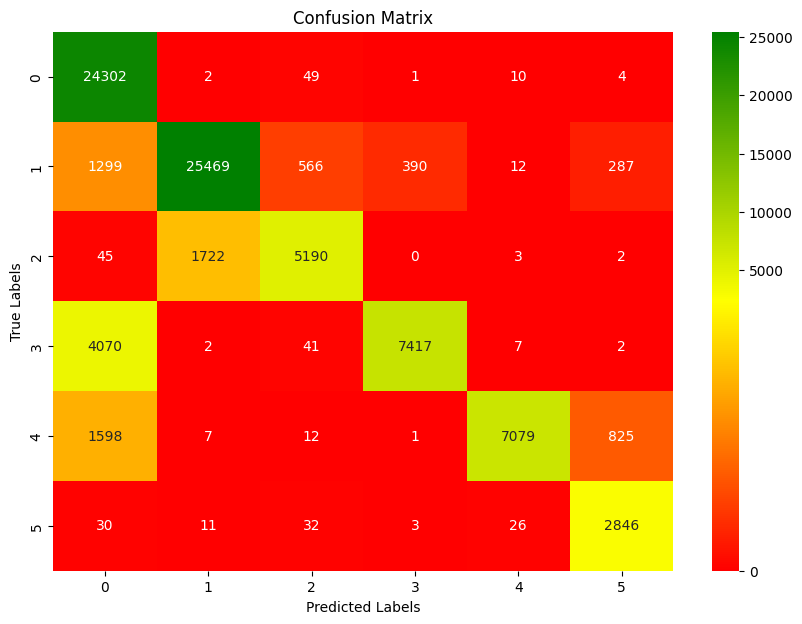

In [26]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.special import softmax
import matplotlib.colors as mcolors

# Get the probabilities of the categories

# Assuming your model has been trained and you have your test set ready
# Predict the probabilities on the test set
probabilities = model.predict(X_tokenized_test)

# Extract logits from the model's output
logits = probabilities.logits

# Apply softmax to logits to get probabilities
probabilities = softmax(logits, axis=1)

# Convert probabilities to predicted classes
predictions = np.argmax(probabilities, axis=1)

# Generate the confusion matrix
cm = confusion_matrix(y_test, predictions)

# Define a custom colormap
cmap = mcolors.LinearSegmentedColormap.from_list(
    name='red_green_map', 
    colors=['red', 'yellow', 'green']
)

# Normalize the colormap to ensure that the diagonal (correct predictions) is green
norm = mcolors.TwoSlopeNorm(vmin=0, vcenter=np.mean(cm), vmax=np.max(cm))

# Plot the confusion matrix using Seaborn with the custom colormap
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap=cmap, norm=norm)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

Now let us also print the classification report, which will give us a summary of the model's performance on each class.

In [28]:
# Print the classification report
from sklearn.metrics import classification_report

print(classification_report(y_test, predictions, target_names=categories))

              precision    recall  f1-score   support

     sadness       0.78      1.00      0.87     24368
         joy       0.94      0.91      0.92     28023
        love       0.88      0.75      0.81      6962
       anger       0.95      0.64      0.77     11539
        fear       0.99      0.74      0.85      9522
    surprise       0.72      0.97      0.82      2948

    accuracy                           0.87     83362
   macro avg       0.88      0.83      0.84     83362
weighted avg       0.88      0.87      0.86     83362



The classification report evaluates the performance of a model across multiple classes (in our case sadness, joy, love, anger, fear, surprise). Each class's performance is assessed using precision, recall, and the F1-score alongside the number of samples (support) for each class.

Starting with **precision**, which indicates the accuracy of positive predictions for each emotion, the model performs best at predicting fear with a precision of 0.99, suggesting that nearly all predictions made by the model for fear are correct. Anger and joy also have high precision scores (0.95 and 0.94, respectively), meaning the model is reliable when it predicts these emotions. In contrast, surprise has the lowest precision at 0.72, indicating a higher rate of false positives for this class - this is to be expected, as it is the class which shows less often in the dataset.

**Recall**, or the ability of the model to find all relevant cases within a dataset, is perfect for sadness at 1.00, meaning the model identifies all instances of sadness in the dataset. Surprise and joy also have high recall rates (0.97 and 0.91, respectively), showing that the model is capable of detecting most instances of these emotions. Anger has the lowest recall at 0.64.

The **F1-score** provides a balance between precision and recall, taking into account both false positives and false negatives. Joy scores the highest with an F1-score of 0.92, indicative of a well-balanced precision and recall. Sadness and fear follow with F1-scores of 0.87 and 0.85, respectively. Anger, despite its high precision, has a lower F1-score of 0.77 due to its poor recall rate.

The **support** column shows the number of actual occurrences of each class in the dataset, which informs us about the imbalance in the dataset's composition. Joy has the highest number of samples at 28,023, followed by sadness at 24,368, which might explain the model's effectiveness at identifying these emotions due to more extensive training data.

Overall, the model achieves an **accuracy** of 0.87 across all predictions, which is quite high. The macro average for precision, recall, and F1-score are 0.88, 0.83, and 0.84 respectively, indicating good general performance across all classes. The weighted average, which accounts for the support of each class, shows similar performance with values of 0.88 for precision and 0.86 for F1-score, suggesting consistent performance weighted by the prevalence of each emotion in the dataset. This report highlights strengths in identifying sadness, joy, and fear effectively while pointing out weaknesses in detecting all instances of anger accurately.

## Final remarks

In this experiment, we fine-tuned a pre-trained BERT model for text classification using the TensorFlow and Transformers libraries. We used the Emotion Dataset from the Hugging Face datasets library, which contains text samples labeled with one of six emotions: sadness, joy, love, anger, fear, and surprise. We used the `distilbert-base-uncased` model to create a text classification model and trained it on the dataset. We evaluated the model's performance using the validation set and calculated metrics like precision, recall, and F1-score for each class. The model achieved an accuracy of 0.87 and showed strengths in identifying sadness, joy, and fear effectively. The classification report provided a detailed summary of the model's performance on each class, highlighting areas of strength and areas for improvement.